In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from imblearn.combine import SMOTETomek
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier
from sklearn.svm import SVC
import sklearn.metrics as metrics
from imblearn.over_sampling import SMOTE
from sklearn.cross_validation import *
from sklearn.grid_search import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
%matplotlib inline

/home/ashwin/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/ashwin/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


[192 422]
1    422
0    192
Name: data, dtype: int64


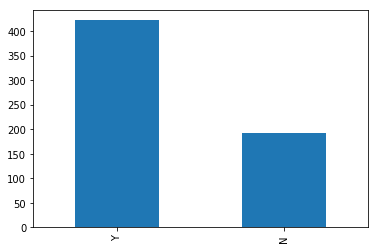

In [2]:
train_data=pd.read_csv('/home/ashwin/Downloads/AV/loan/train.csv')
test_data=pd.read_csv('/home/ashwin/Downloads/AV/loan/test.csv')
le = preprocessing.LabelEncoder()
target=le.fit_transform(train_data['Loan_Status'])
print( np.bincount(target))
df = pd.DataFrame({'data':target})
print(df['data'].value_counts())
train_data['Loan_Status'].value_counts().plot(kind='bar')

In [3]:
print(train_data.shape)
print(test_data.shape)

(614, 13)
(367, 12)


In [4]:
print(train_data.head())
print(train_data.shape)

    Loan_ID Gender Married Dependents     Education Self_Employed  \
0  LP001002   Male      No          0      Graduate            No   
1  LP001003   Male     Yes          1      Graduate            No   
2  LP001005   Male     Yes          0      Graduate           Yes   
3  LP001006   Male     Yes          0  Not Graduate            No   
4  LP001008   Male      No          0      Graduate            No   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             5849                0.0         NaN             360.0   
1             4583             1508.0       128.0             360.0   
2             3000                0.0        66.0             360.0   
3             2583             2358.0       120.0             360.0   
4             6000                0.0       141.0             360.0   

   Credit_History Property_Area Loan_Status  
0             1.0         Urban           Y  
1             1.0         Rural           N  
2             1.0   

In [5]:
train_data.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [6]:
train_data=train_data.drop(['Loan_Status'],axis=1)

In [7]:
combain_data=pd.concat([train_data,test_data],axis=0)

In [8]:
combain_data.shape

(981, 12)

In [9]:
combain_data=combain_data.drop(['Loan_ID'],axis=1)

In [10]:
numerical_var=[f for f in combain_data.columns if combain_data.dtypes[f] 
        != 'object']
catagorical_var=[f for f in combain_data.columns if(combain_data.dtypes[f] 
                 == 'object' or combain_data.dtypes[f] == 'str')]

In [11]:
print(numerical_var,catagorical_var)

['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History'] ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']


In [12]:

for c in numerical_var:
    combain_data[c].fillna(combain_data[c].mean(), inplace=True)
for c in catagorical_var:
    combain_data[c].fillna(combain_data[c].mode()[0], inplace=True)

In [13]:
combain_data.isnull().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
dtype: int64

In [14]:
list(combain_data)

['Gender',
 'Married',
 'Dependents',
 'Education',
 'Self_Employed',
 'ApplicantIncome',
 'CoapplicantIncome',
 'LoanAmount',
 'Loan_Amount_Term',
 'Credit_History',
 'Property_Area']

In [15]:

combain_data['ApplicantIncome_CoapplicantIncome']=\
    combain_data.ApplicantIncome*combain_data.CoapplicantIncome
combain_data['LoanAmount_Loan_Amount_Term']=\
    combain_data.Loan_Amount_Term*combain_data.LoanAmount
combain_data['Loan_Amount_Term_Credit_History']=\
    combain_data.Credit_History*combain_data.Loan_Amount_Term

combain_data['ApplicantIncome_LoanAmount']=\
    combain_data.ApplicantIncome*combain_data.LoanAmount
combain_data['CoapplicantIncome_LoanAmount']=\
    combain_data.CoapplicantIncome*combain_data.LoanAmount
combain_data['ApplicantIncome_Credit_History']=\
    combain_data.ApplicantIncome*combain_data.Credit_History
combain_data['CoapplicantIncome_Credit_History']=\
    combain_data.CoapplicantIncome*combain_data.Credit_History

combain_data['1_2_3']=combain_data.ApplicantIncome_LoanAmount\
                      *combain_data.CoapplicantIncome_LoanAmount\
                      *combain_data.ApplicantIncome_Credit_History
combain_data['2_3_4']=combain_data.CoapplicantIncome_LoanAmount\
                      *combain_data.ApplicantIncome_Credit_History\
                      *combain_data.CoapplicantIncome_Credit_History
combain_data['3_4_1']=combain_data.ApplicantIncome_Credit_History\
                      *combain_data.CoapplicantIncome_Credit_History\
                      *combain_data.ApplicantIncome_LoanAmount
combain_data['4_1_2']=combain_data.CoapplicantIncome_Credit_History\
                      *combain_data.ApplicantIncome_LoanAmount\
                      *combain_data.CoapplicantIncome_LoanAmount

combain_data['Gender_Married'] = \
    combain_data[['Gender', 'Married']].apply(lambda x: ''.join(x), axis=1)
combain_data['Gender_Dependents'] = \
    combain_data[['Gender', 'Dependents']].apply(lambda x: ''.join(x), axis=1)
combain_data['Gender_Education'] = \
    combain_data[['Gender', 'Education']].apply(lambda x: ''.join(x), axis=1)
combain_data['Gender_Property_Area'] = \
    combain_data[['Gender', 'Property_Area']].apply(lambda x: ''.join(x), axis=1)
combain_data['Gender_Self_Employed'] = \
    combain_data[['Gender', 'Self_Employed']].apply(lambda x: ''.join(x), axis=1)
combain_data['Education_Self_Employed'] = \
    combain_data[['Education', 'Self_Employed']].apply(lambda x: ''.join(x), axis=1)

numerical_var=[f for f in combain_data.columns if combain_data.dtypes[f] 
        != 'object']
catagorical_var=[f for f in combain_data.columns if(combain_data.dtypes[f] 
                 == 'object' or combain_data.dtypes[f] == 'str')]

In [16]:
for c in numerical_var:
    print(stats.skew(combain_data[c]))
    print(stats.kurtosis(combain_data[c]))
    print('----------------')

7.076120215680954
71.03253946795378
----------------
6.833639135606733
76.95759034089552
----------------
2.7478447940023436
11.888026300496897
----------------
-2.499129996894611
7.537708270500019
----------------
-1.8918527405960814
1.666689940659662
----------------
7.498193820892884
77.62550038930908
----------------
2.6594549849676765
13.90906000876127
----------------
-1.4022155291568843
0.36168617528073765
----------------
9.420438091790905
106.69305154999091
----------------
11.95328802013916
218.57226663850966
----------------
5.972681718108678
57.70593995918707
----------------
6.710699311221501
74.44491173489772
----------------
17.845033926311586
349.221563040032
----------------
11.650649506618251
158.84252013053788
----------------
13.308932166575364
195.6168162927431
----------------
13.903026244364584
218.27703519938342
----------------


In [17]:
scaler = StandardScaler()
i=0
while(i<=1):
    for c in numerical_var:
        if(stats.skew(combain_data[c])>0 and stats.skew(combain_data[c])>0.75):
            combain_data[c]=np.log1p(combain_data[c])
        elif(stats.skew(combain_data[c])<0 and stats.skew(combain_data[c])<-0.75):
            combain_data[c] = combain_data[c]**3
            combain_data[c] = scaler.fit_transform(combain_data[[c]])
    i=i+1

In [18]:
dummified_data=pd.get_dummies(combain_data[catagorical_var])
print(dummified_data.shape)

(981, 45)


In [19]:
combain_data=combain_data.drop(catagorical_var,axis=1)

In [20]:
combain_data=pd.concat([combain_data,dummified_data],axis=1)
print(combain_data.shape)

In [21]:
train_data=combain_data[:614]
test_data=combain_data[614:]
print(train_data.shape)
print(test_data.shape)

(614, 61)
(367, 61)


In [22]:
sm_svm = SMOTE(random_state=12,ratio=1,n_jobs=-1,kind='svm')
x_synthitic_data,y_synthitic_data = sm_svm.fit_sample(train_data, target)
#x_synthitic_data,y_synthitic_data = sm_svm.fit_sample(x_synthitic_data,y_synthitic_data)
#x_synthitic_data,y_synthitic_data = sm_svm.fit_sample(x_synthitic_data,y_synthitic_data)
print(x_synthitic_data.shape)
#print( np.bincount(y_synthitic_data))

/home/ashwin/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


(843, 61)


In [24]:
test=pd.read_csv('/home/ashwin/Downloads/AV/loan/test.csv')
model=SVC()
param_grid = [
 {'C': [100,250,500], 'kernel': ['linear']},
{'C': [1, 10, 100, 200,300,500,600], 'gamma': [0.1,0.01,0.001, 0.0001], 'kernel': ['rbf','sigmoid']},
]
SVM_model = GridSearchCV(model, param_grid=param_grid,
               n_jobs=-1,scoring='roc_auc',refit=True)
SVM_model.fit(train_data,target)
print(SVM_model.best_params_,SVM_model.best_score_)
predictions=SVM_model.predict(train_data)
print('accuracy',metrics.accuracy_score(target,predictions))
print('recall',metrics.recall_score(target,predictions))
print('precision',metrics.precision_score(target,predictions))
print('auc-roc',metrics.roc_auc_score(target,predictions))

print(pd.crosstab(target, predictions, rownames=['True'], 
            colnames=['Predicted'], margins=True))
predictions=SVM_model.predict(test_data)
predictions1=['N' if(x==0) else 'Y' for x in predictions ]
submission=pd.DataFrame()
submission['Loan_ID']=test['Loan_ID']
submission['Loan_Status']=predictions1
submission.to_csv('/home/ashwin/Downloads/AV/loan/submissionsvm_new.csv'
                  ,index=False)


{'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'} 0.7773490484193539
accuracy 0.776872964169
recall 0.985781990521
precision 0.760511882998
auc-roc 0.651745161927
Predicted   0    1  All
True                   
0          61  131  192
1           6  416  422
All        67  547  614


In [28]:
test=pd.read_csv('/home/ashwin/Downloads/AV/loan/test.csv')
n_estimators=50
model=BaggingClassifier(SVC(C=250,kernel='rbf',gamma=0.1,
     probability=True)
    , max_samples=1.0 / n_estimators, n_estimators=n_estimators,n_jobs=-1)
model.fit(train_data,target)
#predictions=model.predict(train_data)
#print('SVM Classifier train/valadiation result')
#print('accuracy',metrics.accuracy_score(target,predictions))
#print('recall',metrics.recall_score(target,predictions))
#print('precision',metrics.precision_score(target,predictions))
#print('auc-roc',metrics.roc_auc_score(target,predictions))
#pd.crosstab(target, predictions, rownames=['True'], 
#            colnames=['Predicted'], margins=True)
predictions=model.predict(test_data)
predictions1=['N' if(x==0) else 'Y' for x in predictions ]
submission=pd.DataFrame()
submission['Loan_ID']=test['Loan_ID']
submission['Loan_Status']=predictions1
submission.to_csv('/home/ashwin/Downloads/AV/loan/submissionsvm.csv'
                  ,index=False)

In [27]:
model=RandomForestClassifier()
param_dist = {"max_depth": [None],
              "max_features": ["auto"],
              "min_samples_split": [6,7,8],
              "min_samples_leaf": [1,3,5,7],
              "bootstrap": [True],
              "criterion": ["gini", "entropy"],
              "n_estimators":[250,500,1000],
              #"n_jobs":[-1],
              "oob_score":[True,False],
              "random_state":[True,False]
              }
RF_model = GridSearchCV(model, param_grid=param_dist,
                n_jobs=-1,scoring='roc_auc',refit=True)
RF_model.fit(train_data,target)
print(RF_model.best_params_,RF_model.best_score_)
predictions=RF_model.predict(train_data)
print('accuracy',metrics.accuracy_score(target,predictions))
print('recall',metrics.recall_score(target,predictions))
print('precision',metrics.precision_score(target,predictions))
print('auc-roc',metrics.roc_auc_score(target,predictions))

print(pd.crosstab(target, predictions, rownames=['True'], 
            colnames=['Predicted'], margins=True))

predictions=RF_model.predict(test_data)
predictions1=['N' if(x==0) else 'Y' for x in predictions ]
submission=pd.DataFrame()
submission['Loan_ID']=test['Loan_ID']
submission['Loan_Status']=predictions1
submission.to_csv('/home/ashwin/Downloads/AV/loan/submissionrf.csv'
                  ,index=False)

{'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 500, 'oob_score': True, 'random_state': True} 0.7805476848459947
accuracy 0.920195439739
recall 0.985781990521
precision 0.906318082789
auc-roc 0.880911828594
Predicted    0    1  All
True                    
0          149   43  192
1            6  416  422
All        155  459  614


In [28]:
test=pd.read_csv('/home/ashwin/Downloads/AV/loan/test.csv')
model=LogisticRegression()
grid_values = {'penalty': ['l1'], 'C': [0.001,0.005,0.01,0.05,0.1
    ,0.5,1,10,100,1000],
               'solver' : ['liblinear','saga'],
               'max_iter':[10000,20000,30000,40000,50000]}
logistic_model = GridSearchCV(model, param_grid=grid_values,
                cv=StratifiedKFold(target, n_folds=3, shuffle=True),
                n_jobs=-1,scoring='roc_auc',refit=True)
logistic_model.fit(train_data,target)
print(logistic_model.best_params_,logistic_model.best_score_)
predictions=logistic_model.predict(train_data)
print('Logistic Regression Classifier Train/valadiation result')
print('accuracy',metrics.accuracy_score(target,predictions))
print('recall',metrics.recall_score(target,predictions))
print('precision',metrics.precision_score(target,predictions))
print('auc-roc',metrics.roc_auc_score(target,predictions))
print(pd.crosstab(target, predictions, rownames=['True'], 
            colnames=['Predicted'], margins=True))
predictions=logistic_model.predict(test_data)
predictions1=['N' if(x==0) else 'Y' for x in predictions ]
submission=pd.DataFrame()
submission['Loan_ID']=test['Loan_ID']
submission['Loan_Status']=predictions1
submission.to_csv('/home/ashwin/Downloads/AV/loan/submissionlog.csv'
                  ,index=False)




{'C': 1, 'max_iter': 10000, 'penalty': 'l1', 'solver': 'saga'} 0.7406938562468441
Logistic Regression Classifier Train/valadiation result
accuracy 0.807817589577
recall 0.978672985782
precision 0.791187739464
auc-roc 0.705482326224
Predicted   0    1  All
True                   
0          83  109  192
1           9  413  422
All        92  522  614


In [24]:
test=pd.read_csv('/home/ashwin/Downloads/AV/loan/test.csv')
xgb_model = xgb.XGBClassifier()
parameters = {'objective':['binary:logistic'],
              'learning_rate': [0.001,0.005,0.01,0.05,0.1,0.5], #so called `eta` value
              'max_depth': [7,8,9,10],
             'min_child_weight': [6,7,8,9,10],
              'silent': [1],
              'subsample': [0.4,0.5,0.6,0.7],
              'colsample_bytree': [0.6,0.7,0.8],
              'n_estimators': [150],
              'seed': [100]}
clf = GridSearchCV(xgb_model, parameters, n_jobs=-1, 
                   cv=StratifiedKFold(target, n_folds=3, shuffle=True), 
                   scoring='roc_auc',
                   refit=True)
clf.fit(train_data.as_matrix(),target)
print(clf.best_params_,clf.best_score_)
predictions=clf.predict(train_data.as_matrix())
print('Logistic Regression Classifier Train/valadiation result')
print('accuracy',metrics.accuracy_score(target,predictions))
print('recall',metrics.recall_score(target,predictions))
print('precision',metrics.precision_score(target,predictions))
print('auc-roc',metrics.roc_auc_score(target,predictions))
print(pd.crosstab(target, predictions, rownames=['True'], 
            colnames=['Predicted'], margins=True))
predictions=clf.predict(test_data.as_matrix())
predictions1=['N' if(x==0) else 'Y' for x in predictions ]
submission=pd.DataFrame()
submission['Loan_ID']=test['Loan_ID']
submission['Loan_Status']=predictions1
submission.to_csv('/home/ashwin/Downloads/AV/loan/submissionxgb.csv'
                  ,index=False)

{'colsample_bytree': 0.6, 'learning_rate': 0.001, 'max_depth': 7, 'min_child_weight': 9, 'n_estimators': 150, 'objective': 'binary:logistic', 'seed': 100, 'silent': 1, 'subsample': 0.6} 0.7649117115745738
Logistic Regression Classifier Train/valadiation result
accuracy 0.811074918567
recall 0.983412322275
precision 0.791984732824
auc-roc 0.707851994471
Predicted   0    1  All
True                   
0          83  109  192
1           7  415  422
All        90  524  614


In [26]:
naive_byase = BernoulliNB()
naive_byase.fit(train_data,target)
predictions=naive_byase.predict(train_data)
print('Logistic Regression Classifier Train/valadiation result')
print('accuracy',metrics.accuracy_score(target,predictions))
print('recall',metrics.recall_score(target,predictions))
print('precision',metrics.precision_score(target,predictions))
print('auc-roc',metrics.roc_auc_score(target,predictions))
print(pd.crosstab(target, predictions, rownames=['True'], 
            colnames=['Predicted'], margins=True))
predictions=naive_byase.predict(test_data.as_matrix())
predictions1=['N' if(x==0) else 'Y' for x in predictions ]
submission=pd.DataFrame()
submission['Loan_ID']=test['Loan_ID']
submission['Loan_Status']=predictions1
submission.to_csv('/home/ashwin/Downloads/AV/loan/submissionnaive.csv'
                  ,index=False)

Logistic Regression Classifier Train/valadiation result
accuracy 0.635179153094
recall 0.594786729858
precision 0.825657894737
auc-roc 0.659372531596
Predicted    0    1  All
True                    
0          139   53  192
1          171  251  422
All        310  304  614
